In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.model_selection import train_test_split, GridSearchCV#, PredefinedSplit
from sklearn.metrics import mean_squared_error, make_scorer

from xgboost import XGBRegressor
from xgboost import plot_tree

# Data Prep

**Repositioning Column "INFECTION RATE" to the end of the dataset**

In [2]:
data = pd.read_csv('final_data_cleaned.csv')
data['INFECTION RATE'].isnull().any() 
# no null value in 'INFECTION RATE' --> treat 0.0 as missing values

False

In [3]:
infection_rate = data['INFECTION RATE']
infection_rate

0       0.034420
1       0.031714
2       0.034908
3       0.057709
4       0.020817
          ...   
3142    0.015867
3143    0.229845
3144    0.019409
3145    0.061508
3146    0.000000
Name: INFECTION RATE, Length: 3147, dtype: float64

In [4]:
data = data.drop('INFECTION RATE', axis = 1)
data

,GEO_ID,COUNTY,STATE,POPULATION,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,...,UNEMP_60-64,UNEMP_65-74,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),POP DENSITY
0,0500000US01001,Autauga County,Alabama,55200.0,7.0,6.0,6.6,6.2,7.5,4.9,...,3.2,1.5,0.0,64.150362,34.150362,37.731884,60.568841,26.865672,598.73,92.195146
1,0500000US01003,Baldwin County,Alabama,208107.0,6.1,5.2,5.7,5.5,6.9,7.1,...,2.0,3.2,2.6,72.480022,28.537243,35.510098,65.507167,26.865672,1737.68,119.761406
2,0500000US01005,Barbour County,Alabama,25782.0,5.6,6.4,7.2,7.0,6.4,6.4,...,1.2,3.0,9.2,40.745481,45.857575,49.169964,37.433093,26.865672,891.30,28.926287
3,0500000US01007,Bibb County,Alabama,22527.0,6.7,6.6,6.9,6.7,6.6,5.4,...,1.9,4.5,0.0,55.440139,35.495184,39.836640,51.098682,26.865672,624.10,36.095177
4,0500000US01009,Blount County,Alabama,57645.0,6.4,5.5,5.9,5.9,6.8,6.3,...,3.0,2.4,0.0,66.657993,33.015873,36.308440,63.365426,26.865672,646.77,89.127511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,0500000US56037,Sweetwater County,Wyoming,44117.0,7.2,6.2,7.1,7.7,7.0,6.1,...,2.2,3.3,0.0,67.901263,30.160709,21.155110,76.906861,56.521739,10435.46,4.227605
3143,0500000US56039,Teton County,Wyoming,23059.0,4.0,4.8,9.3,9.1,6.4,6.6,...,0.2,5.9,0.0,80.935860,20.451884,20.104948,81.282796,56.521739,4077.70,5.654903
3144,0500000US56041,Uinta County,Wyoming,20609.0,7.2,5.5,5.4,6.5,8.5,5.7,...,0.2,10.6,15.2,78.752002,19.840846,24.688243,73.904605,56.521739,2084.15,9.888444
3145,0500000US56043,Washakie County,Wyoming,8129.0,7.1,5.0,4.6,5.0,7.1,7.5,...,7.4,4.8,0.0,87.025355,38.863278,55.295402,70.593231,56.521739,2241.18,3.627107


In [5]:
data.insert(101, "INFECTION RATE", infection_rate)
data

,GEO_ID,COUNTY,STATE,POPULATION,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,...,UNEMP_65-74,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),POP DENSITY,INFECTION RATE
0,0500000US01001,Autauga County,Alabama,55200.0,7.0,6.0,6.6,6.2,7.5,4.9,...,1.5,0.0,64.150362,34.150362,37.731884,60.568841,26.865672,598.73,92.195146,0.034420
1,0500000US01003,Baldwin County,Alabama,208107.0,6.1,5.2,5.7,5.5,6.9,7.1,...,3.2,2.6,72.480022,28.537243,35.510098,65.507167,26.865672,1737.68,119.761406,0.031714
2,0500000US01005,Barbour County,Alabama,25782.0,5.6,6.4,7.2,7.0,6.4,6.4,...,3.0,9.2,40.745481,45.857575,49.169964,37.433093,26.865672,891.30,28.926287,0.034908
3,0500000US01007,Bibb County,Alabama,22527.0,6.7,6.6,6.9,6.7,6.6,5.4,...,4.5,0.0,55.440139,35.495184,39.836640,51.098682,26.865672,624.10,36.095177,0.057709
4,0500000US01009,Blount County,Alabama,57645.0,6.4,5.5,5.9,5.9,6.8,6.3,...,2.4,0.0,66.657993,33.015873,36.308440,63.365426,26.865672,646.77,89.127511,0.020817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,0500000US56037,Sweetwater County,Wyoming,44117.0,7.2,6.2,7.1,7.7,7.0,6.1,...,3.3,0.0,67.901263,30.160709,21.155110,76.906861,56.521739,10435.46,4.227605,0.015867
3143,0500000US56039,Teton County,Wyoming,23059.0,4.0,4.8,9.3,9.1,6.4,6.6,...,5.9,0.0,80.935860,20.451884,20.104948,81.282796,56.521739,4077.70,5.654903,0.229845
3144,0500000US56041,Uinta County,Wyoming,20609.0,7.2,5.5,5.4,6.5,8.5,5.7,...,10.6,15.2,78.752002,19.840846,24.688243,73.904605,56.521739,2084.15,9.888444,0.019409
3145,0500000US56043,Washakie County,Wyoming,8129.0,7.1,5.0,4.6,5.0,7.1,7.5,...,4.8,0.0,87.025355,38.863278,55.295402,70.593231,56.521739,2241.18,3.627107,0.061508


**Identify Prediction Set (Counties with 0.0% Infection Rate)**

In [6]:
pred_set = data.loc[data['INFECTION RATE'] == 0.0]
data = data.drop(pred_set.index)
data

,GEO_ID,COUNTY,STATE,POPULATION,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,...,UNEMP_65-74,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),POP DENSITY,INFECTION RATE
0,0500000US01001,Autauga County,Alabama,55200.0,7.0,6.0,6.6,6.2,7.5,4.9,...,1.5,0.0,64.150362,34.150362,37.731884,60.568841,26.865672,598.73,92.195146,0.034420
1,0500000US01003,Baldwin County,Alabama,208107.0,6.1,5.2,5.7,5.5,6.9,7.1,...,3.2,2.6,72.480022,28.537243,35.510098,65.507167,26.865672,1737.68,119.761406,0.031714
2,0500000US01005,Barbour County,Alabama,25782.0,5.6,6.4,7.2,7.0,6.4,6.4,...,3.0,9.2,40.745481,45.857575,49.169964,37.433093,26.865672,891.30,28.926287,0.034908
3,0500000US01007,Bibb County,Alabama,22527.0,6.7,6.6,6.9,6.7,6.6,5.4,...,4.5,0.0,55.440139,35.495184,39.836640,51.098682,26.865672,624.10,36.095177,0.057709
4,0500000US01009,Blount County,Alabama,57645.0,6.4,5.5,5.9,5.9,6.8,6.3,...,2.4,0.0,66.657993,33.015873,36.308440,63.365426,26.865672,646.77,89.127511,0.020817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,0500000US56035,Sublette County,Wyoming,9951.0,6.6,3.4,4.7,6.0,7.3,6.8,...,0.0,0.0,73.540479,45.684151,64.640821,54.583808,56.521739,4898.98,2.031239,0.010049
3142,0500000US56037,Sweetwater County,Wyoming,44117.0,7.2,6.2,7.1,7.7,7.0,6.1,...,3.3,0.0,67.901263,30.160709,21.155110,76.906861,56.521739,10435.46,4.227605,0.015867
3143,0500000US56039,Teton County,Wyoming,23059.0,4.0,4.8,9.3,9.1,6.4,6.6,...,5.9,0.0,80.935860,20.451884,20.104948,81.282796,56.521739,4077.70,5.654903,0.229845
3144,0500000US56041,Uinta County,Wyoming,20609.0,7.2,5.5,5.4,6.5,8.5,5.7,...,10.6,15.2,78.752002,19.840846,24.688243,73.904605,56.521739,2084.15,9.888444,0.019409


In [7]:
pred_set

,GEO_ID,COUNTY,STATE,POPULATION,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,...,UNEMP_65-74,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),POP DENSITY,INFECTION RATE
30,0500000US01061,Geneva County,Alabama,26491.0,6.3,5.3,5.4,5.8,7.7,6.4,...,0.9,0.0,55.233853,41.312144,46.098675,50.447322,26.865672,577.13,45.901270,0.0
67,0500000US02013,Aleutians East Borough,Alaska,3425.0,5.0,6.9,8.1,6.3,7.7,7.2,...,0.0,0.0,87.025355,38.863278,55.295402,70.593231,82.758621,8496.37,0.403113,0.0
68,0500000US02016,Aleutians West Census Area,Alaska,5750.0,4.8,9.2,8.6,8.8,7.4,6.6,...,0.0,0.0,73.540479,45.684151,64.640821,54.583808,82.758621,8718.39,0.659525,0.0
71,0500000US02060,Bristol Bay Borough,Alaska,890.0,5.1,4.3,5.8,4.4,11.7,8.4,...,9.5,42.9,73.540479,45.684151,64.640821,54.583808,82.758621,644.05,1.381880,0.0
72,0500000US02068,Denali Borough,Alaska,2232.0,5.6,13.4,5.5,6.5,7.6,14.2,...,4.8,0.0,87.025355,38.863278,55.295402,70.593231,82.758621,6379.26,0.349884,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,0500000US55123,Vernon County,Wisconsin,30516.0,6.6,4.7,4.6,5.0,8.0,7.5,...,1.6,1.3,59.444226,40.339494,38.914012,60.869708,25.000000,803.66,37.971281,0.0
3117,0500000US55129,Washburn County,Wisconsin,15689.0,5.0,4.0,3.9,4.7,8.8,9.4,...,1.7,1.1,87.025355,38.863278,55.295402,70.593231,25.000000,822.91,19.065268,0.0
3125,0500000US56003,Big Horn County,Wyoming,11901.0,7.0,4.5,5.0,5.6,6.2,7.4,...,1.9,2.7,87.025355,38.863278,55.295402,70.593231,56.521739,3144.78,3.784366,0.0
3139,0500000US56031,Platte County,Wyoming,8673.0,5.7,4.9,4.3,5.4,6.4,9.3,...,0.0,0.0,87.025355,38.863278,55.295402,70.593231,56.521739,2083.22,4.163266,0.0


**Identify the X and y from Data and Prediction Set**

In [8]:
X = data.iloc[:, 4:101]
X = X.drop("LAND AREA(SQMI)", axis = 1) # No total population or land area
y = data["INFECTION RATE"]
X

,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,TOTAL_MALE,TOTAL_FEMALE,PERCENT_FEMALE,PERCENT_MALE,...,UNEMP_55-59,UNEMP_60-64,UNEMP_65-74,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,POP DENSITY
0,7.0,6.0,6.6,6.2,7.5,4.9,26874.0,28326.0,51.315217,48.684783,...,1.4,3.2,1.5,0.0,64.150362,34.150362,37.731884,60.568841,26.865672,92.195146
1,6.1,5.2,5.7,5.5,6.9,7.1,101188.0,106919.0,51.376936,48.623064,...,1.4,2.0,3.2,2.6,72.480022,28.537243,35.510098,65.507167,26.865672,119.761406
2,5.6,6.4,7.2,7.0,6.4,6.4,13697.0,12085.0,46.873788,53.126212,...,3.4,1.2,3.0,9.2,40.745481,45.857575,49.169964,37.433093,26.865672,28.926287
3,6.7,6.6,6.9,6.7,6.6,5.4,12152.0,10375.0,46.055844,53.944156,...,0.6,1.9,4.5,0.0,55.440139,35.495184,39.836640,51.098682,26.865672,36.095177
4,6.4,5.5,5.9,5.9,6.8,6.3,28434.0,29211.0,50.673953,49.326047,...,2.5,3.0,2.4,0.0,66.657993,33.015873,36.308440,63.365426,26.865672,89.127511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,6.6,3.4,4.7,6.0,7.3,6.8,5367.0,4584.0,46.065722,53.934278,...,12.8,0.0,0.0,0.0,73.540479,45.684151,64.640821,54.583808,56.521739,2.031239
3142,7.2,6.2,7.1,7.7,7.0,6.1,22882.0,21235.0,48.133373,51.866627,...,5.5,2.2,3.3,0.0,67.901263,30.160709,21.155110,76.906861,56.521739,4.227605
3143,4.0,4.8,9.3,9.1,6.4,6.6,11911.0,11148.0,48.345548,51.654452,...,0.0,0.2,5.9,0.0,80.935860,20.451884,20.104948,81.282796,56.521739,5.654903
3144,7.2,5.5,5.4,6.5,8.5,5.7,10505.0,10104.0,49.027124,50.972876,...,1.2,0.2,10.6,15.2,78.752002,19.840846,24.688243,73.904605,56.521739,9.888444


In [9]:
pred_X = pred_set.iloc[:, 4:101]
pred_X = pred_X.drop("LAND AREA(SQMI)", axis = 1) # No total population or land area
pred_X

,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,TOTAL_MALE,TOTAL_FEMALE,PERCENT_FEMALE,PERCENT_MALE,...,UNEMP_55-59,UNEMP_60-64,UNEMP_65-74,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,POP DENSITY
30,6.3,5.3,5.4,5.8,7.7,6.4,12971.0,13520.0,51.036201,48.963799,...,3.1,0.4,0.9,0.0,55.233853,41.312144,46.098675,50.447322,26.865672,45.901270
67,5.0,6.9,8.1,6.3,7.7,7.2,1989.0,1436.0,41.927007,58.072993,...,7.4,0.0,0.0,0.0,87.025355,38.863278,55.295402,70.593231,82.758621,0.403113
68,4.8,9.2,8.6,8.8,7.4,6.6,3432.0,2318.0,40.313043,59.686957,...,2.3,0.3,0.0,0.0,73.540479,45.684151,64.640821,54.583808,82.758621,0.659525
71,5.1,4.3,5.8,4.4,11.7,8.4,526.0,364.0,40.898876,59.101124,...,3.9,3.9,9.5,42.9,73.540479,45.684151,64.640821,54.583808,82.758621,1.381880
72,5.6,13.4,5.5,6.5,7.6,14.2,1117.0,1115.0,49.955197,50.044803,...,1.4,0.0,4.8,0.0,87.025355,38.863278,55.295402,70.593231,82.758621,0.349884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,6.6,4.7,4.6,5.0,8.0,7.5,15302.0,15214.0,49.855813,50.144187,...,2.1,1.8,1.6,1.3,59.444226,40.339494,38.914012,60.869708,25.000000,37.971281
3117,5.0,4.0,3.9,4.7,8.8,9.4,7771.0,7918.0,50.468481,49.531519,...,3.8,3.0,1.7,1.1,87.025355,38.863278,55.295402,70.593231,25.000000,19.065268
3125,7.0,4.5,5.0,5.6,6.2,7.4,6033.0,5868.0,49.306781,50.693219,...,3.0,4.3,1.9,2.7,87.025355,38.863278,55.295402,70.593231,56.521739,3.784366
3139,5.7,4.9,4.3,5.4,6.4,9.3,4499.0,4174.0,48.126369,51.873631,...,0.0,0.0,0.0,0.0,87.025355,38.863278,55.295402,70.593231,56.521739,4.163266


**Split Data into 2/3 Training and 1/3 Testing**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# SKLearn GradientBoostingRegressor

**Baseline SKLearn GradientBoostingRegressor Model**

In [11]:
gbr_model = ensemble.GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)
mean_squared_error(y_test, gbr_model.predict(X_test))

0.021947699641357853

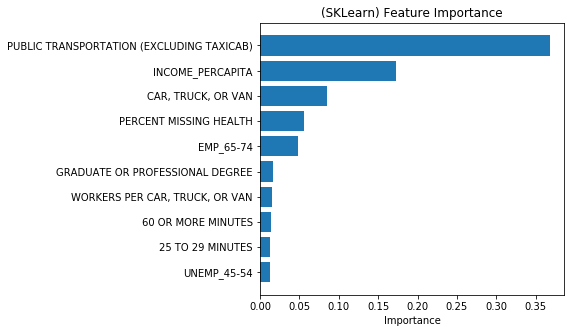

In [12]:
feature_importance = gbr_model.feature_importances_
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
top_10 = sorted_idx[-10:]
pos = np.arange(top_10.shape[0]) + .5
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[top_10], align='center')
plt.yticks(pos, X.columns[top_10])
plt.xlabel('Importance')
plt.title('(SKLearn) Feature Importance')
plt.show()

**SKLearn: Hyperparameter Tuning**

In [13]:
# test_fold = [-1]*len(X_train) + [0]*len(X_test)
# predefined_split = PredefinedSplit(test_fold=test_fold)
# predefined_split

In [14]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.001, 0.01, 0.1]
}
gbr = ensemble.GradientBoostingRegressor()
grid = GridSearchCV(
    gbr,
    param_grid,
    scoring = make_scorer(mean_squared_error, greater_is_better = False),
    return_train_score=True
)
grid.fit(X_train, y_train)

# pd.set_option('display.max_rows', 5)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better = FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_learning_rate", "param_max_depth","param_min_samples_split", "param_n_estimators",
                "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow = df_toshow.sort_values(by=["mean_test_score"])
df_toshow.head()

,param_learning_rate,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,mean_train_score
77,0.1,7,4,700,0.028691,9.971871e-08
63,0.1,5,2,300,0.028881,1.571907e-05
58,0.1,3,4,500,0.029330,2.378812e-04
76,0.1,7,4,500,0.029502,9.971871e-08
59,0.1,3,4,700,0.029542,8.969921e-05


In [15]:
best_params = df_toshow.head(1)

params = {
    'n_estimators': best_params['param_n_estimators'].item(), 
    'max_depth': best_params['param_max_depth'].item(), 
    'min_samples_split': best_params['param_min_samples_split'].item(),
    'learning_rate': best_params['param_learning_rate'].item(), 
    'loss': 'ls', 'criterion': 'mse'
}
gbr_model = ensemble.GradientBoostingRegressor(**params)
gbr_model.fit(X_train, y_train)
mean_squared_error(y_test, gbr_model.predict(X_test))

# better than the baseline model

0.02152621365972335

In [16]:
# # baseline default parameter values
# params = {
#     'n_estimators': 100, 
#     'max_depth': 3, 
#     'min_samples_split': 2,
#     'learning_rate': 0.1, 
#     'loss': 'ls', 'criterion': 'mse'
# }
# gbr_model = ensemble.GradientBoostingRegressor(**params)
# gbr_model.fit(X_train, y_train)
# mean_squared_error(y_test, gbr_model.predict(X_test))

0.020923567549823194

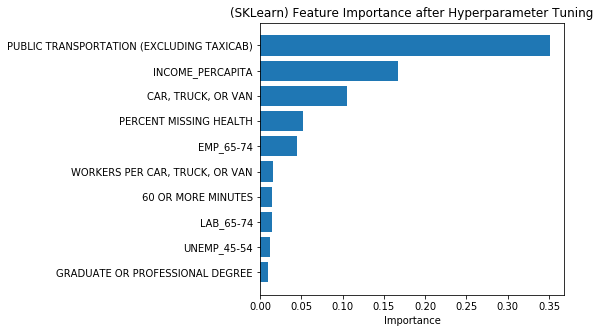

In [17]:
feature_importance = gbr_model.feature_importances_
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
top_10 = sorted_idx[-10:]
pos = np.arange(top_10.shape[0]) + .5
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[top_10], align='center')
plt.yticks(pos, X.columns[top_10])
plt.xlabel('Importance')
plt.title('(SKLearn) Feature Importance after Hyperparameter Tuning')
plt.show()

**SKLearn Infection Rate Prediction**

In [18]:
infection_rate_predictions = gbr_model.predict(pred_X)
pred_set["INFECTION RATE"] = infection_rate_predictions
pred_set

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,GEO_ID,COUNTY,STATE,POPULATION,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,...,UNEMP_65-74,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),POP DENSITY,INFECTION RATE
30,0500000US01061,Geneva County,Alabama,26491.0,6.3,5.3,5.4,5.8,7.7,6.4,...,0.9,0.0,55.233853,41.312144,46.098675,50.447322,26.865672,577.13,45.901270,0.061231
67,0500000US02013,Aleutians East Borough,Alaska,3425.0,5.0,6.9,8.1,6.3,7.7,7.2,...,0.0,0.0,87.025355,38.863278,55.295402,70.593231,82.758621,8496.37,0.403113,1.638606
68,0500000US02016,Aleutians West Census Area,Alaska,5750.0,4.8,9.2,8.6,8.8,7.4,6.6,...,0.0,0.0,73.540479,45.684151,64.640821,54.583808,82.758621,8718.39,0.659525,1.576182
71,0500000US02060,Bristol Bay Borough,Alaska,890.0,5.1,4.3,5.8,4.4,11.7,8.4,...,9.5,42.9,73.540479,45.684151,64.640821,54.583808,82.758621,644.05,1.381880,0.243423
72,0500000US02068,Denali Borough,Alaska,2232.0,5.6,13.4,5.5,6.5,7.6,14.2,...,4.8,0.0,87.025355,38.863278,55.295402,70.593231,82.758621,6379.26,0.349884,0.161363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,0500000US55123,Vernon County,Wisconsin,30516.0,6.6,4.7,4.6,5.0,8.0,7.5,...,1.6,1.3,59.444226,40.339494,38.914012,60.869708,25.000000,803.66,37.971281,0.042071
3117,0500000US55129,Washburn County,Wisconsin,15689.0,5.0,4.0,3.9,4.7,8.8,9.4,...,1.7,1.1,87.025355,38.863278,55.295402,70.593231,25.000000,822.91,19.065268,0.028588
3125,0500000US56003,Big Horn County,Wyoming,11901.0,7.0,4.5,5.0,5.6,6.2,7.4,...,1.9,2.7,87.025355,38.863278,55.295402,70.593231,56.521739,3144.78,3.784366,0.022994
3139,0500000US56031,Platte County,Wyoming,8673.0,5.7,4.9,4.3,5.4,6.4,9.3,...,0.0,0.0,87.025355,38.863278,55.295402,70.593231,56.521739,2083.22,4.163266,0.026027


# XGBRegressor

**Baseline XGBRegressor Model**

In [19]:
xgbr_model = XGBRegressor()
xgbr_model.fit(X_train, y_train)
mean_squared_error(y_test, xgbr_model.predict(X_test))

0.021640949145811064

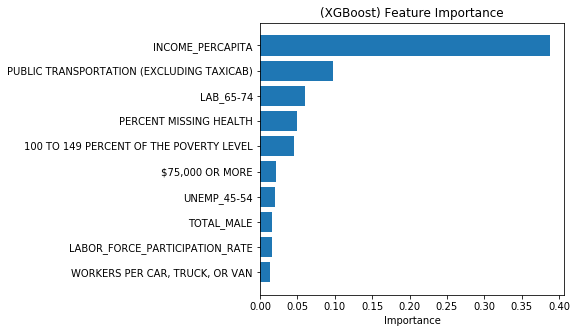

In [20]:
feature_importance = xgbr_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_10 = sorted_idx[-10:]
pos = np.arange(top_10.shape[0]) + .5
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[top_10], align='center')
plt.yticks(pos, X.columns[top_10])
plt.xlabel('Importance')
plt.title('(XGBoost) Feature Importance')
plt.show()

In [21]:
plot_tree(xgbr_model)
fig = plt.gcf()
fig.set_size_inches(300, 400)
plt.title('(XGBoost) Gradient Boosting Tree')
plt.show()

**XGBRegressor: Hyperparameter Tuning**

In [22]:
xparam_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [2, 4, 6],
    'gamma': [0, 0.1, 0.2],
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.001, 0.01, 0.1]
}
xgbr = XGBRegressor()
xgrid = GridSearchCV(
    xgbr,
    xparam_grid,
    scoring = make_scorer(mean_squared_error, greater_is_better = False),
    return_train_score=True
)
xgrid.fit(X_train, y_train)

# pd.set_option('display.max_rows', 20)
xdf = pd.DataFrame(xgrid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better = FALSE"
xdf['mean_test_score'] = -xdf['mean_test_score']
xdf['mean_train_score'] = -xdf['mean_train_score']
cols_to_keep = ["param_gamma", "param_learning_rate", "param_max_depth",
                "param_min_child_weight", "param_n_estimators",
                "mean_test_score","mean_train_score"]
xdf_toshow = xdf[cols_to_keep].fillna('-')
xdf_toshow = xdf_toshow.sort_values(by=["mean_test_score"])
xdf_toshow.head()

,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,mean_test_score,mean_train_score
48,0.0,0.01,7,4,300,0.031274,0.012526
49,0.0,0.01,7,4,500,0.031416,0.007916
129,0.1,0.01,7,4,300,0.031571,0.012948
120,0.1,0.01,5,4,300,0.031767,0.014514
40,0.0,0.01,5,4,500,0.031814,0.010021


In [23]:
xbest_params = xdf_toshow.head(1)

xparams = {
    'n_estimators': xbest_params['param_n_estimators'].item(), 
    'max_depth': xbest_params['param_max_depth'].item(), 
    'min_child_weight': xbest_params['param_min_child_weight'].item(),
    'learning_rate': xbest_params['param_learning_rate'].item(),
    'gamma': xbest_params['param_gamma'].item(),
    'loss': 'ls', 'criterion': 'mse'
}
xgbr_model = XGBRegressor(**params)
xgbr_model.fit(X_train, y_train)
mean_squared_error(y_test, xgbr_model.predict(X_test))

# Better than baseline model

0.021893282566083853

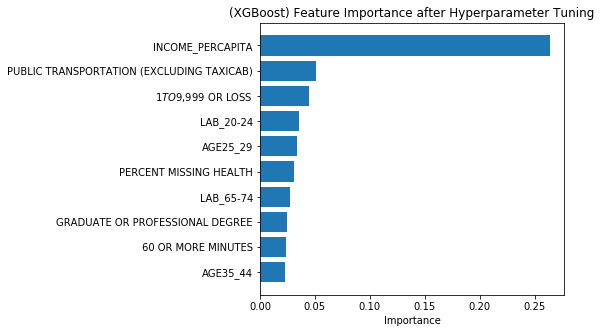

In [24]:
feature_importance = xgbr_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_10 = sorted_idx[-10:]
pos = np.arange(top_10.shape[0]) + .5
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[top_10], align='center')
plt.yticks(pos, X.columns[top_10])
plt.xlabel('Importance')
plt.title('(XGBoost) Feature Importance after Hyperparameter Tuning')
plt.show()

In [25]:
plot_tree(xgbr_model)
fig = plt.gcf()
fig.set_size_inches(300, 400)
plt.title('(XGBoost) Gradient Boosting Tree after Hyperparameter Tuning')
plt.show()

**XGBoost Infection Rate Prediction**

In [26]:
xinfection_rate_predictions = xgbr_model.predict(pred_X)
pred_set["XGBOOST INFECTION RATE"] = xinfection_rate_predictions
pred_set

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,GEO_ID,COUNTY,STATE,POPULATION,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,...,UNEMP_OVER75,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),POP DENSITY,INFECTION RATE,XGBOOST INFECTION RATE
30,0500000US01061,Geneva County,Alabama,26491.0,6.3,5.3,5.4,5.8,7.7,6.4,...,0.0,55.233853,41.312144,46.098675,50.447322,26.865672,577.13,45.901270,0.061231,0.059972
67,0500000US02013,Aleutians East Borough,Alaska,3425.0,5.0,6.9,8.1,6.3,7.7,7.2,...,0.0,87.025355,38.863278,55.295402,70.593231,82.758621,8496.37,0.403113,1.638606,1.198174
68,0500000US02016,Aleutians West Census Area,Alaska,5750.0,4.8,9.2,8.6,8.8,7.4,6.6,...,0.0,73.540479,45.684151,64.640821,54.583808,82.758621,8718.39,0.659525,1.576182,1.223737
71,0500000US02060,Bristol Bay Borough,Alaska,890.0,5.1,4.3,5.8,4.4,11.7,8.4,...,42.9,73.540479,45.684151,64.640821,54.583808,82.758621,644.05,1.381880,0.243423,0.211108
72,0500000US02068,Denali Borough,Alaska,2232.0,5.6,13.4,5.5,6.5,7.6,14.2,...,0.0,87.025355,38.863278,55.295402,70.593231,82.758621,6379.26,0.349884,0.161363,0.176404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,0500000US55123,Vernon County,Wisconsin,30516.0,6.6,4.7,4.6,5.0,8.0,7.5,...,1.3,59.444226,40.339494,38.914012,60.869708,25.000000,803.66,37.971281,0.042071,0.042299
3117,0500000US55129,Washburn County,Wisconsin,15689.0,5.0,4.0,3.9,4.7,8.8,9.4,...,1.1,87.025355,38.863278,55.295402,70.593231,25.000000,822.91,19.065268,0.028588,0.028202
3125,0500000US56003,Big Horn County,Wyoming,11901.0,7.0,4.5,5.0,5.6,6.2,7.4,...,2.7,87.025355,38.863278,55.295402,70.593231,56.521739,3144.78,3.784366,0.022994,0.024786
3139,0500000US56031,Platte County,Wyoming,8673.0,5.7,4.9,4.3,5.4,6.4,9.3,...,0.0,87.025355,38.863278,55.295402,70.593231,56.521739,2083.22,4.163266,0.026027,0.024200


In [27]:
sum(pred_set["INFECTION RATE"] - pred_set["XGBOOST INFECTION RATE"])/len(pred_set)

0.037845463844030786

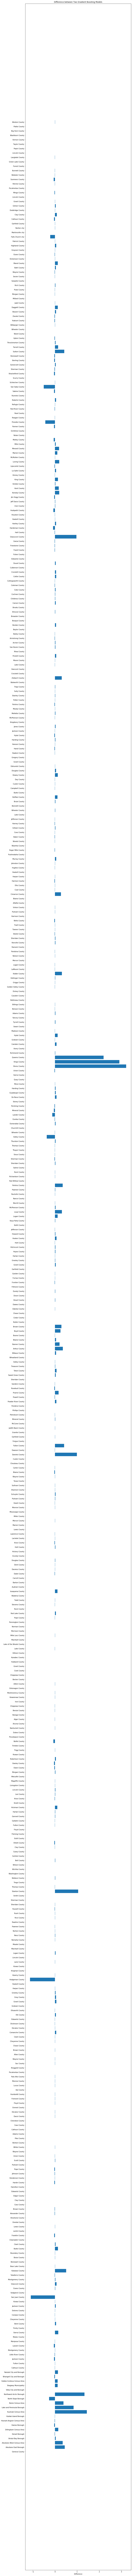

In [28]:
difference = pred_set["INFECTION RATE"] - pred_set["XGBOOST INFECTION RATE"]

plt.figure(figsize=(12, 300))
plt.barh(np.arange(len(pred_set)), difference, align='center')
plt.yticks(np.arange(len(pred_set)), pred_set["COUNTY"])
plt.xlabel('Difference')
plt.title('Difference between Two Gradient Boosting Models')

plt.show()

In [29]:
pred_set["DIFF"] = difference
pred_set

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,GEO_ID,COUNTY,STATE,POPULATION,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,...,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),POP DENSITY,INFECTION RATE,XGBOOST INFECTION RATE,DIFF
30,0500000US01061,Geneva County,Alabama,26491.0,6.3,5.3,5.4,5.8,7.7,6.4,...,55.233853,41.312144,46.098675,50.447322,26.865672,577.13,45.901270,0.061231,0.059972,0.001258
67,0500000US02013,Aleutians East Borough,Alaska,3425.0,5.0,6.9,8.1,6.3,7.7,7.2,...,87.025355,38.863278,55.295402,70.593231,82.758621,8496.37,0.403113,1.638606,1.198174,0.440431
68,0500000US02016,Aleutians West Census Area,Alaska,5750.0,4.8,9.2,8.6,8.8,7.4,6.6,...,73.540479,45.684151,64.640821,54.583808,82.758621,8718.39,0.659525,1.576182,1.223737,0.352445
71,0500000US02060,Bristol Bay Borough,Alaska,890.0,5.1,4.3,5.8,4.4,11.7,8.4,...,73.540479,45.684151,64.640821,54.583808,82.758621,644.05,1.381880,0.243423,0.211108,0.032315
72,0500000US02068,Denali Borough,Alaska,2232.0,5.6,13.4,5.5,6.5,7.6,14.2,...,87.025355,38.863278,55.295402,70.593231,82.758621,6379.26,0.349884,0.161363,0.176404,-0.015041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,0500000US55123,Vernon County,Wisconsin,30516.0,6.6,4.7,4.6,5.0,8.0,7.5,...,59.444226,40.339494,38.914012,60.869708,25.000000,803.66,37.971281,0.042071,0.042299,-0.000228
3117,0500000US55129,Washburn County,Wisconsin,15689.0,5.0,4.0,3.9,4.7,8.8,9.4,...,87.025355,38.863278,55.295402,70.593231,25.000000,822.91,19.065268,0.028588,0.028202,0.000386
3125,0500000US56003,Big Horn County,Wyoming,11901.0,7.0,4.5,5.0,5.6,6.2,7.4,...,87.025355,38.863278,55.295402,70.593231,56.521739,3144.78,3.784366,0.022994,0.024786,-0.001792
3139,0500000US56031,Platte County,Wyoming,8673.0,5.7,4.9,4.3,5.4,6.4,9.3,...,87.025355,38.863278,55.295402,70.593231,56.521739,2083.22,4.163266,0.026027,0.024200,0.001828


In [30]:
# 0.3% is the current national infection rate
counties_bigDiff = pred_set.loc[abs(pred_set["DIFF"]) >= 0.3]
counties_bigDiff.sort_values(by=['DIFF'], ascending=False)

,GEO_ID,COUNTY,STATE,POPULATION,AGE15_19,AGE20_24,AGE25_29,AGE30_34,AGE55_59,AGE60_64,...,PERCENT WITH PRIVATE HEALTH INSURANCE,PERCENT NO PRIVATE HEALTH INSURANCE,PERCENT WITH PUBLIC HEALTH INSURANCE,PERCENT NO PUBLIC HEALTH INSURANCE,PERCENT MISSING HEALTH,LAND AREA(SQMI),POP DENSITY,INFECTION RATE,XGBOOST INFECTION RATE,DIFF
1830,0500000US36005,Bronx County,New York,1437872.0,6.8,7.9,8.5,7.3,5.8,5.0,...,46.601366,54.229445,57.727531,43.103280,3.225806,47.12,30515.110357,4.732167,1.511129,3.221038
1851,0500000US36047,Kings County,New York,2600747.0,5.4,6.6,9.5,8.8,5.7,5.3,...,56.503382,44.811010,46.168812,55.145579,3.225806,79.33,32783.902685,4.331292,1.417391,2.913901
1868,0500000US36081,Queens County,New York,2298513.0,5.1,6.2,8.3,7.9,6.8,6.0,...,60.206098,41.765916,41.919363,60.052651,3.225806,131.90,17426.178923,3.539711,1.344422,2.195289
81,0500000US02158,Kusilvak Census Area,Alaska,8198.0,9.1,8.0,8.8,6.6,5.5,3.3,...,42.933990,29.219245,29.450505,42.702730,82.758621,19673.00,0.416713,1.767762,0.328447,1.439315
86,0500000US02188,Northwest Arctic Borough,Alaska,7734.0,8.1,7.7,9.0,6.8,5.1,4.0,...,42.933990,29.219245,29.450505,42.702730,82.758621,36724.89,0.210593,1.526858,0.191075,1.335784
981,0500000US20187,Stanton County,Kansas,2063.0,8.0,3.8,5.5,4.4,7.6,6.3,...,87.025355,38.863278,55.295402,70.593231,72.380952,680.21,3.032887,1.182290,0.134046,1.048244
1607,0500000US30019,Daniels County,Montana,1753.0,5.4,2.1,4.5,2.9,11.5,6.5,...,73.540479,45.684151,64.640821,54.583808,83.928571,1426.39,1.228977,1.080949,0.088428,0.992521
2609,0500000US48173,Glasscock County,Texas,1430.0,9.2,11.0,2.1,6.4,4.8,10.5,...,87.025355,38.863278,55.295402,70.593231,51.181102,900.68,1.587689,1.187157,0.213942,0.973215
82,0500000US02164,Lake and Peninsula Borough,Alaska,1375.0,6.7,9.6,7.6,6.9,8.3,7.4,...,87.025355,38.863278,55.295402,70.593231,82.758621,21830.25,0.062986,1.687251,0.847899,0.839352
548,0500000US15005,Kalawao County,Hawaii,75.0,2.7,0.0,2.7,8.0,26.7,12.0,...,73.540479,45.684151,64.640821,54.583808,20.000000,26.06,2.877974,1.958841,1.451306,0.507535
